# Customer Segmentation

## Load Important Packages

In [2]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import seaborn as sns

## Read The Data

In [6]:
customers = pd.read_excel('E-commerce_data.xlsx', sheet_name='customers')
transactions = pd.read_excel('E-commerce_data.xlsx', sheet_name='transactions')
genders = pd.read_excel('E-commerce_data.xlsx', sheet_name='genders')
cities = pd.read_excel('E-commerce_data.xlsx', sheet_name='cities')
branches = pd.read_excel('E-commerce_data.xlsx', sheet_name='branches')
merchants = pd.read_excel('E-commerce_data.xlsx', sheet_name='merchants')

## Feature Selection and Engineering

In [7]:
# Merge customers with gender and city data
customer_data = customers.merge(genders, on='gender_id', how='left') \
                         .merge(cities, on='city_id', how='left')

In [8]:
# Aggregate transactions data by customer_id (count coupons claimed and burnt)
transaction_agg = transactions.groupby('customer_id').agg({
    'transaction_id': 'count',  # Total number of transactions
    'burn_date': lambda x: x.notnull().sum(),  # Total number of burnt coupons
    'transaction_date': lambda x: (pd.to_datetime(x).max() - pd.to_datetime(x).min()).days
}).reset_index().rename(columns={'transaction_id': 'total_transactions', 'burn_date': 'total_burnt_coupons'})


In [9]:
# Merge the aggregated transactional data with customer demographic data
customer_data = customer_data.merge(transaction_agg, on='customer_id', how='left')

In [10]:
# Fill missing values for customers with no transactions
customer_data['total_transactions'].fillna(0, inplace=True)
customer_data['total_burnt_coupons'].fillna(0, inplace=True)


C:\Users\Dell\AppData\Local\Temp\ipykernel_4560\3752733733.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  customer_data['total_transactions'].fillna(0, inplace=True)
C:\Users\Dell\AppData\Local\Temp\ipykernel_4560\3752733733.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.



## Model Development

In [11]:
# Feature selection: Use demographic and transactional features
X = customer_data[['total_transactions', 'total_burnt_coupons']]

In [12]:
# Normalize the features using StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [13]:
#K-Means Clustering: Explore different cluster sizes (k)
inertia_values = []
silhouette_scores = []

In [14]:
# Test different values of k to find the optimal number of clusters
k_values = range(2, 10)
for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_scaled)
    inertia_values.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(X_scaled, kmeans.labels_))

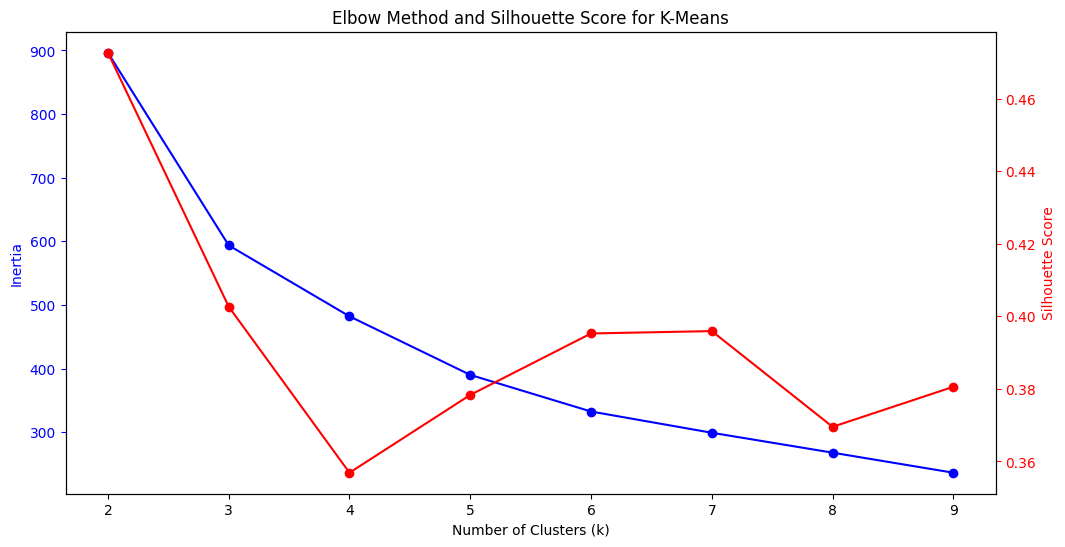

In [15]:
# Plot Inertia (Elbow Method) and Silhouette Score
fig, ax1 = plt.subplots(figsize=(12, 6))

ax1.plot(k_values, inertia_values, 'b-', marker='o', label='Inertia')
ax1.set_xlabel('Number of Clusters (k)')
ax1.set_ylabel('Inertia', color='b')
ax1.tick_params('y', colors='b')

ax2 = ax1.twinx()
ax2.plot(k_values, silhouette_scores, 'r-', marker='o', label='Silhouette Score')
ax2.set_ylabel('Silhouette Score', color='r')
ax2.tick_params('y', colors='r')

plt.title('Elbow Method and Silhouette Score for K-Means')
plt.show()

In [16]:
# Based on the plot, select the optimal number of clusters 
optimal_k = 3
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
customer_data['Cluster'] = kmeans.fit_predict(X_scaled)

In [17]:
#Model Evaluation
silhouette_avg = silhouette_score(X_scaled, customer_data['Cluster'])
print(f'Silhouette Score for K={optimal_k}: {silhouette_avg}')

Silhouette Score for K=3: 0.4026607080613377


## Segment Analysis

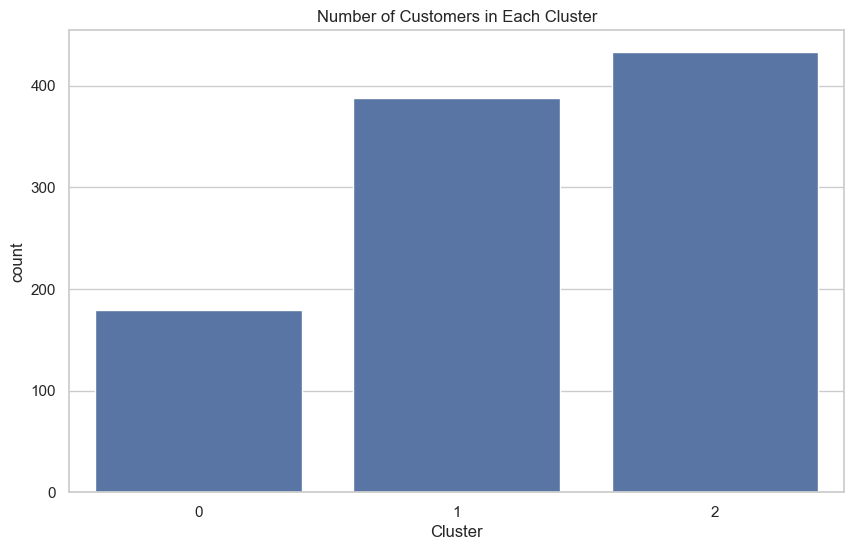

In [18]:
# Analyze the clusters by plotting relevant data
sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))
sns.countplot(data=customer_data, x='Cluster')
plt.title('Number of Customers in Each Cluster')
plt.show()

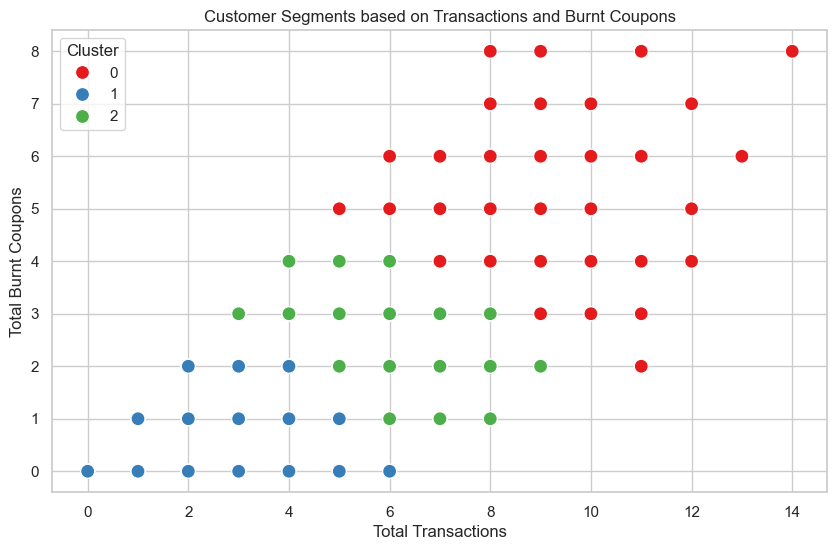

In [21]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=customer_data, x='total_transactions', y='total_burnt_coupons', hue='Cluster', palette='Set1', s=100)
plt.title('Customer Segments based on Transactions and Burnt Coupons')
plt.xlabel('Total Transactions')
plt.ylabel('Total Burnt Coupons')
plt.legend(title='Cluster')
plt.show()

In [19]:
# Analyze the average transactional behavior in each cluster
cluster_analysis = customer_data.groupby('Cluster').agg({
    'total_transactions': 'mean',
    'total_burnt_coupons': 'mean'
}).reset_index()

print(cluster_analysis)

   Cluster  total_transactions  total_burnt_coupons
0        0            8.206704             4.877095
1        1            2.912371             1.115979
2        2            5.545035             2.794457


 Recommendations:
 
 Based on the analysis of clusters, provide coupon and loyalty suggestions:
 
 High transaction and burn rates -> Offer loyalty rewards and premium coupons.
 
 Low transaction rates -> Send reminder coupons or small discounts to re-engage.
 
 New customers -> Offer introductory offers or discounts to encourage first-time use.